<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Определение возраста покупателей

*Описание проекта*    
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
-Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
-Контролировать добросовестность кассиров при продаже алкоголя.  

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
features, target = next(train_gen_flow)

labels.shape

(7591, 2)

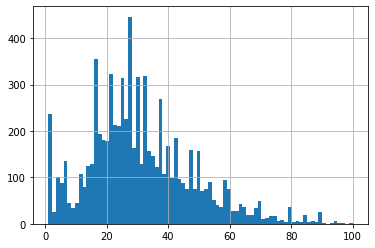

In [5]:
labels['real_age'].hist(bins=80)#(bins=10)

**Вывод**  
Исходная выборка содержит 7591 фотографию людей с разметками о возрасте.  
Основная часть картинок содержит фотограии людей в возрасте от 20 до 30 лет.  

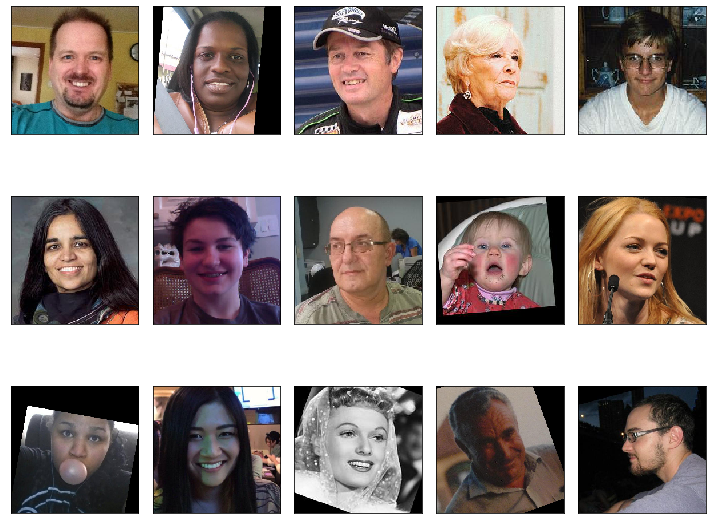

In [5]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout() 

<b>Вывод</b>    
1) В датасете есть старые и черно-белые фотографии. Имеет смысл делать аугментацию с тем, чтобы делать фотографию черно-белой в некотором проценте случаев (нету в стандартном наборе). Возможно, стоит подкрутить цветовые каналы или яркость<br>

2) В датасете есть фотогарафи, на которых лица изображены под разными углами к вертикальной оси. Имеет смысл делать аугментацию с rotation_range равным +-15-20 градусов в некотором проценте случаев. Поворачивать можно как само изображение так и объект отдельно от фона<br>

3) В датасете есть фотогарафи, на которых лица изображены в полупрофиль. Имеет смысл делать аугментацию с отражением по горизонтали в некотором проценте случаев<br>

4) В датасете есть фотогарафи с разным разрешением. Имеет смысл делать аугментацию с изменением контрастности изображения в некотором проценте случаев<br>

5) В датасете есть фотогарафи, на которых изображены не лица, а голова и часть туловища (иногда человек послностью). Имеет смысл делать аугментацию с обезкой и масштабированием изображения в некотором проценте случаев, чтобы на фото были только лица примерно одного масштаба<br>

## Обучение модели

```python

import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50


from tensorflow.keras.optimizers import Adam


labels = pd.read_csv('/datasets/faces/labels.csv')
def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345, subset='training')

    return train_datagen_flow

def load_test(path):
    datagen=ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    val_datagen_flow=datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345, subset='validation')
    
    return val_datagen_flow



def create_model(input_shape):

    backbone = ResNet50(input_shape=(224,224,3),
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```

2021-05-01 11:05:20.351733: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2021-05-01 11:05:21.188951: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2021-05-01 11:05:45.241631: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-05-01 11:05:45.937623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-05-01 11:05:45.937704: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-05-01 11:05:45.937741: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-05-01 11:05:46.307389: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-05-01 11:05:46.468133: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-05-01 11:05:47.843134: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-05-01 11:05:47.942619: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-05-01 11:05:47.942686: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-05-01 11:05:47.946156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-05-01 11:05:47.946616: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-05-01 11:05:48.126672: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2021-05-01 11:05:48.136395: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5682270 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-05-01 11:05:48.136426: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-05-01 11:05:48.536134: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x53fc260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-05-01 11:05:48.536189: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2021-05-01 11:05:48.538090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-05-01 11:05:48.538154: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-05-01 11:05:48.538167: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-05-01 11:05:48.538214: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-05-01 11:05:48.538247: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-05-01 11:05:48.538259: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-05-01 11:05:48.538271: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-05-01 11:05:48.538280: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-05-01 11:05:48.541634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-05-01 11:05:48.552082: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-05-01 11:05:57.600288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-05-01 11:05:57.600338: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2021-05-01 11:05:57.600348: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2021-05-01 11:05:57.619761: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/5
2021-05-01 11:06:44.469318: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-05-01 11:06:48.602577: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 110s - loss: 330.2077 - mae: 12.8518 - val_loss: 1158.1847 - val_mae: 29.6162
Epoch 2/5
178/178 - 37s - loss: 71.4986 - mae: 6.3573 - val_loss: 500.7926 - val_mae: 16.9227
Epoch 3/5
178/178 - 37s - loss: 33.0626 - mae: 4.4226 - val_loss: 192.8336 - val_mae: 10.4340
Epoch 4/5
178/178 - 37s - loss: 19.5316 - mae: 3.3966 - val_loss: 110.6394 - val_mae: 8.1469
Epoch 5/5
178/178 - 37s - loss: 14.8083 - mae: 2.9944 - val_loss: 80.4722 - val_mae: 6.8379
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 80.4722 - mae: 6.8379
Test MAE: 6.8379
```

## Вывод

Построена и обучена свёрточная нейронная сеть на датасете с фотографиями людей. Я применяла архитектуру ResNet50.  
Результат работы модели МАЕ на тестовой выборке 6.84.  